In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import levy_stable

In [93]:
class GD():
    def __init__(self, gamma, max_iter, x_start, func,  noise, sign=False, delta=1, epsilon=0, sigma=0, kappa=2):
        self.gamma = gamma
        self.max_iter = max_iter
        self.x_current = jnp.array(x_start, dtype=jnp.float64)  # Преобразуем в массив JAX
        self.x_srart = x_start  # Преобразуем в массив JAX
        self.func = func
        self.logger = []
        self.sign = sign
        self.epsilon = epsilon
        self.delta = delta
        self.sigma = sigma
        self.kappa = kappa
        self.noise = noise

    def compute_grad(self):
        grad_func = jax.grad(self.func)  # Создаем функцию градиента
        return grad_func(self.x_current)  # Вычисляем градиент в текущей точке

    def step(self):
        grad = self.compute_grad() + noise # Получаем градиент
        if self.sign:
          grad = np.sign(grad)
        self.x_current = self.x_current - self.gamma * grad  # Обновляем точку

    def run(self):
        self.logger.append(self.x_current.copy())  # Сохраняем начальную точку
        if self.epsilon == 0:
          for _ in range(self.max_iter):
            self.step()  # Выполняем шаг
            self.logger.append(self.x_current.copy())  # Сохраняем новое значение
        else: pass

    def get_logger(self):
        return self.logger

In [75]:
dataset = "mushrooms.txt"
#файл должен лежать в той же директории, что и notebook
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), (data[1] - 1.5)*2
n, d = X.shape

In [76]:
n, d

(8124, 112)

In [77]:
# Training parameters
num_epochs = 100
learning_rate = 0.01
alpha = 1.6    # For κ = 1.5
beta = 0
loc = 0
scale = 0.5   # Small scale to avoid overpowering gradients
noise = np.array(levy_stable.rvs(alpha, beta, loc=loc, scale=scale, size=d))

In [78]:
from sklearn.model_selection import train_test_split
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set: {X_train.shape[0]} obj., Test  set: {X_test.shape[0]} obj.")

Train set: 6499 obj., Test  set: 1625 obj.


In [79]:
X_train.shape

(6499, 112)

In [13]:
# Максимальная норма объектов
R = np.max(np.linalg.norm(X_train, axis=1, ord=2))
# R2 = np.linalg.norm(X_train @ X_train.T, ord=2)
print(R)
lambda_reg = 1.0
L1 = R + lambda_reg
L = R**2 + lambda_reg
print(f"L = {L}, L_1 = {L1}.")

4.58257569495584
L = 22.0, L_1 = 5.58257569495584.


In [80]:
from functools import partial
# Функция потерь (логистическая с регуляризацией)
def logistic_loss(w, X, y, lambda_reg):
    z = y * (X @ w)
    return jnp.mean(jnp.log(1 + jnp.exp(-z))) + (lambda_reg / 2) * jnp.sum(w**2)


In [81]:
w_0 =  np.random.normal(1, 3, X.shape[1])

In [32]:
def calculate_gamma_l1(l_1, delta, d):
  gamma = 1 / (48 * l_1 * d**(3/2) * np.log(1/delta))
  return gamma
def calculate_gamma(l, delta, d):
  gamma = 1 / (8 * l**2 * d**(2) * np.log(1/delta)**2)**(1/2)
  return gamma

In [82]:
delta = 0.99
gammal1 = 1 / (L1 * d**(3/2) * np.log(1 / delta))
gammal = 1 / (L * d**(3/2) * np.log(1 / delta))

In [83]:
print((f"gamma_l = {gammal}, gamma_l1 = {gammal1}."))

gamma_l = 0.0038156603600980363, gamma_l1 = 0.01503688127292304.


In [117]:
# Запуск градиентного спуска с шумами
max_iter = 2000
func2 = partial(logistic_loss, X=X_train, y=y_train, lambda_reg=lambda_reg)
methodl = GD(gammal, max_iter, w_0, func2, noise, sign=False)
methodl.run()
loggerl = methodl.get_logger()

<ipython-input-93-7ccf6145aafb>:5: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  self.x_current = jnp.array(x_start, dtype=jnp.float64)  # Преобразуем в массив JAX


In [ ]:
# Запуск sign градиентного спуска с шумами
w_0 =  np.random.normal(1, 3, X.shape[1])
max_iter = 2000
func2 = partial(logistic_loss, X=X_train, y=y_train, lambda_reg=lambda_reg)
methodl1 = GD(gammal1, max_iter, w_0, func2, noise, sign=True)
methodl1.run()
loggerl1 = methodl1.get_logger()

In [104]:
def stochastic_gradient(x):
    alpha = 1.6    # For κ = 1.5
    beta = 0
    loc = 0
    scale = 0.5   # Small scale to avoid overpowering gradients
    noise = np.array(levy_stable.rvs(alpha, beta, loc=loc, scale=scale, size=d))
    return x + noise

def train(alg, N_steps, repeats, loss, gammal, gammal1):
    runs = np.zeros([N_steps,repeats])
    for rep in range(repeats):
        x = np.random.normal(size=d)
        f_values = []
        for step in range(N_steps):
            f_values.append(loss(x))
            if alg == 'sgd':
                update = stochastic_gradient((jax.grad(loss))(x))
                x -= gammal * update
            elif alg == 'signSGD':
                update = np.sign(stochastic_gradient((jax.grad(loss))(x)))
                x -= gammal1 * update
#             x -= lr/np.sqrt(step+1) * update
        runs[:,rep] = np.asarray(f_values)
    return runs

In [102]:
max_iter = 1000
func2 = partial(logistic_loss, X=X_train, y=y_train, lambda_reg=lambda_reg)

In [105]:
N_steps = 1000
repeats = 10
sgd_runs = train('sgd', N_steps=N_steps, repeats=repeats, loss=func2, gammal=gammal, gammal1=gammal1)
signSGD_runs = train('signSGD',N_steps=N_steps, repeats=repeats, loss=func2, gammal=gammal, gammal1=gammal1)

In [109]:
def processRuns(runs):
    mean = np.mean(runs,axis=1)
    std = np.std(runs,axis=1)
    return mean, std

sgd_mean, sgd_var = processRuns(sgd_runs)
sign_mean, sign_var = processRuns(signSGD_runs)

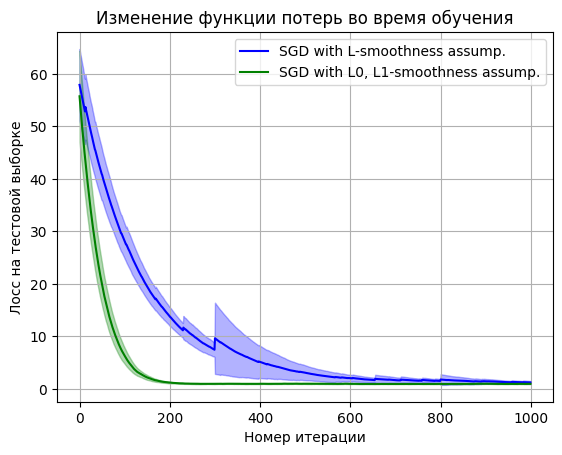

In [116]:
plt.plot(sgd_mean, label='SGD with L-smoothness assump.', color='blue')
plt.fill_between(range(N_steps),sgd_mean - sgd_var, sgd_mean+sgd_var,alpha=0.3, edgecolor='blue', facecolor='blue')
plt.plot(sign_mean, label='SGD with L0, L1-smoothness assump.', color='green')
plt.fill_between(range(N_steps),sign_mean - sign_var, sign_mean+sign_var,alpha=0.3, edgecolor='green', facecolor='green')
plt.xlabel('Номер итерации')
plt.ylabel('Лосс на тестовой выборке')
plt.title('Изменение функции потерь во время обучения')
plt.legend()
plt.grid(True)
plt.show()

In [118]:
def predict(w, X, y):
    return np.mean(jnp.sign(X @ w) == y_test)

In [120]:
acc = partial(predict, X=X_test, y=y_test)

In [122]:
def train2(alg, N_steps, repeats, gammal, gammal1, acc, loss):
    runs = np.zeros([N_steps,repeats])
    for rep in range(repeats):
        x = np.random.normal(size=d)
        f_values = []
        for step in range(N_steps):
            f_values.append(acc(x) * 100)
            if alg == 'sgd':
                update = stochastic_gradient((jax.grad(loss))(x))
                x -= gammal * update
            elif alg == 'signSGD':
                update = np.sign(stochastic_gradient((jax.grad(loss))(x)))
                x -= gammal1 * update
#             x -= lr/np.sqrt(step+1) * update
        runs[:,rep] = np.asarray(f_values)
    return runs

In [124]:
N_steps = 1000
repeats = 10
acc_sgd_runs = train2('sgd', N_steps=N_steps, repeats=repeats, gammal=gammal, gammal1=gammal1, acc=acc, loss=func2)
acc_signSGD_runs = train2('signSGD',N_steps=N_steps, repeats=repeats, gammal=gammal, gammal1=gammal1, acc=acc, loss=func2)

In [125]:
acc_sgd_mean, acc_sgd_var = processRuns(acc_sgd_runs)
acc_sign_mean, acc_sign_var = processRuns(acc_signSGD_runs)

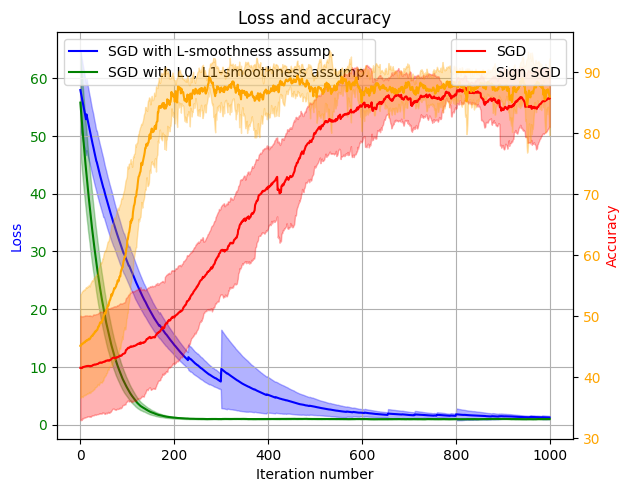

In [131]:
fig, ax1 = plt.subplots()
color = 'blue'
ax1.set_xlabel('Iteration number')
ax1.set_ylabel('Loss', color=color)
ax1.plot(sgd_mean, label='SGD with L-smoothness assump.', color=color)
ax1.fill_between(range(N_steps), sgd_mean - sgd_var, sgd_mean + sgd_var, alpha=0.3, edgecolor=color, facecolor=color)
color = 'green'
ax1.plot(sign_mean, label='SGD with L0, L1-smoothness assump.', color=color)
ax1.fill_between(range(N_steps), sign_mean - sign_var, sign_mean + sign_var, alpha=0.3, edgecolor=color, facecolor=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(acc_sgd_mean, label='SGD', color=color)
ax2.fill_between(range(N_steps), acc_sgd_mean - acc_sgd_var, acc_sgd_mean + acc_sgd_var, alpha=0.3, edgecolor=color, facecolor=color)
color = 'orange'
ax2.plot(acc_sign_mean, label='Sign SGD', color=color)
ax2.fill_between(range(N_steps), acc_sign_mean - acc_sign_var, acc_sign_mean + acc_sign_var, alpha=0.3, edgecolor=color, facecolor=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Loss and accuracy')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)
plt.show()
